In [1]:
import utils.graph_utils

DATA_PATH = 'C:/Users/amityu/Gel_Sheet_Data/'
#movie = 'Control'
#movie = '130721'
#movie ='140721'
#movie ='150721'
#movie ='100621'
movie = '130721_CCA60_RAW'
#movie ='280523 AM100 568'
#movie = 'control_1_050721'

MOVIE_PATH = DATA_PATH +  movie + '/'
GRAPH_PATH = 'C:/Users/amityu/Gel_Sheet_Graph/'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from  skimage.filters import gaussian
from tqdm.notebook import trange, tqdm
import pandas as pd
from objects import movie_structure
from objects.movie_structure import gaussian_curvature, mean_curvature

import importlib
import seaborn as sns
#import scalar_mappable
from matplotlib.cm import ScalarMappable
#import gaussian_filter
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import  utils.graph_utils as graph_utils

In [3]:
surface = np.load(MOVIE_PATH + 'np/height.npy')
membrane = np.load(MOVIE_PATH + 'np/membrane.npy')
gel = np.load(MOVIE_PATH + 'np/gel_norm.npy')

In [4]:
del gel


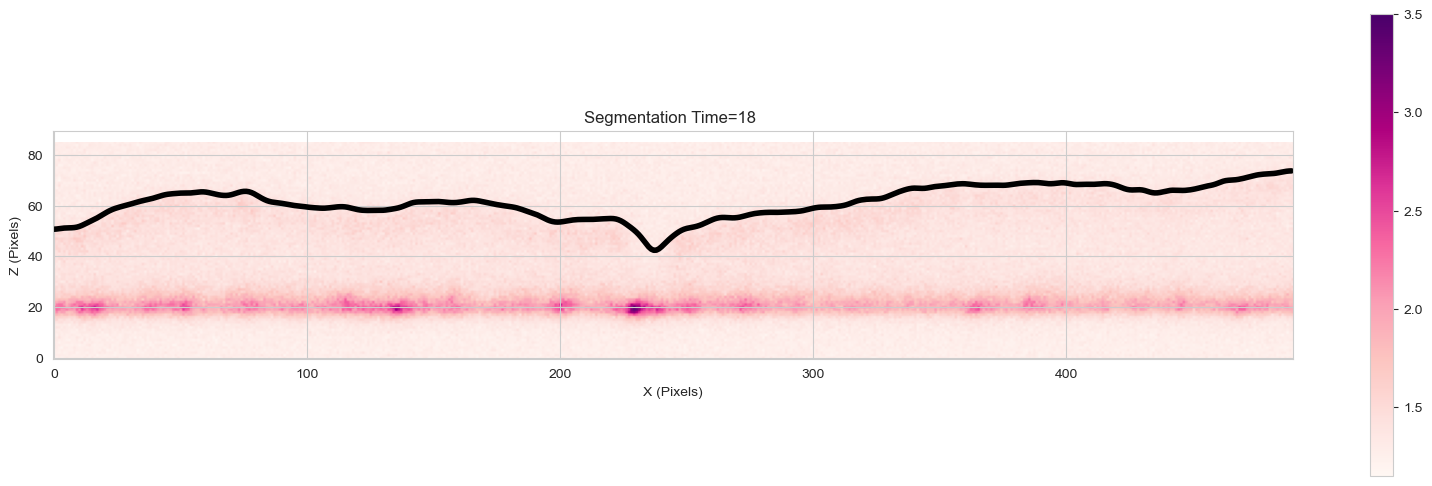

In [47]:
movie = '130721_CCA60_RAW'
MOVIE_PATH = DATA_PATH +  movie + '/'

surface = np.load(MOVIE_PATH + 'np/height.npy')
membrane = np.load(MOVIE_PATH + 'np/membrane.npy')
gel = np.load(MOVIE_PATH + 'np/gel_norm.npy')
t = 18

y = 350
x1 = 10
x2 = 500
z1 = 0
z2 = 90
plot_sigma = 2.5
fig,ax1 = plt.subplots(1,1,figsize=(20,20))
h = surface[t]
m = membrane[t]+3
#sm = ScalarMappable(cmap='coolwarm')
#sm.set_array(h)
#cbar = plt.colorbar(sm)
img = gel[t,z1:z2,y,x1:x2].copy()
pixel_size_x = 0.168
pixel_size_y = 0.270

'''up = gaussian_filter(h[y,x1:x2 ],sigma = plot_sigma ).astype(int)
down =gaussian_filter(m[y,x1:x2 ],sigma = plot_sigma ).astype(int)
background_mask = np.zeros((z2-z1,x2-x1), dtype=bool)

for i in range(len(up)):
    background_mask[up[i]:,i] = True
    background_mask[:down[i],i] = True
img[background_mask] = np.nan'''
#img[~background_mask] = 1
# Define extent: left, right, bottom, top
#extent = [0, img.shape[1] * pixel_size_x, 0, img.shape[0] * pixel_size_y]
#norm = Normalize(vmin=np.min(img), vmax=np.max(img))
norm = Normalize(vmin=1.15, vmax=3.5)
colors = plt.cm.RdPu(norm(img))
#plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)
#plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)
mappable = ScalarMappable(norm=norm, cmap=plt.cm.RdPu)
mappable.set_array(img)  # Set the data array

# Now, create the colorbar
plt.colorbar(mappable, ax=ax1, shrink=0.3)

ax1.imshow(img,origin='lower', cmap='RdPu')#, vmin= 1.11, vmax =3.5)#,extent=extent)
ax1.set_xlabel('X (Pixels)')
ax1.set_ylabel('Z (Pixels)')
im = ax1.plot(gaussian_filter(h[y,x1:x2 ],sigma = plot_sigma ), 'black', lw= 4 ,linestyle='-')
#ax1.plot(gaussian_filter(m[y,x1:x2 ],sigma = plot_sigma ), 'w', linestyle='-')

#im= ax2.imshow(h, origin='lower', cmap='coolwarm')

#ax2.set_xlabel('X (Pixels)')
#ax2.set_ylabel('Y (Pixels)')
#ax2.set_title('Surface computed \n y=%d'%y)
plt.title('Segmentation Time=%d ' % t)
# Connect the key press event to the on_key function
#plt.axis('off')
#plt.title("")
#extent = ax1.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
plt.savefig(r'\\132.72.218.248\Yuval_and_Shachar\evolution paper\\' + '%s_sideview_t%dy%d+membrane.png'%(movie,t,y))#, bbox_inches=extent)
plt.show()


In [38]:
print(np.nanmin(img), np.nanmax(img))

0.8590969244748746 3.466340160954446


## <span color='red'> TOP VIEW

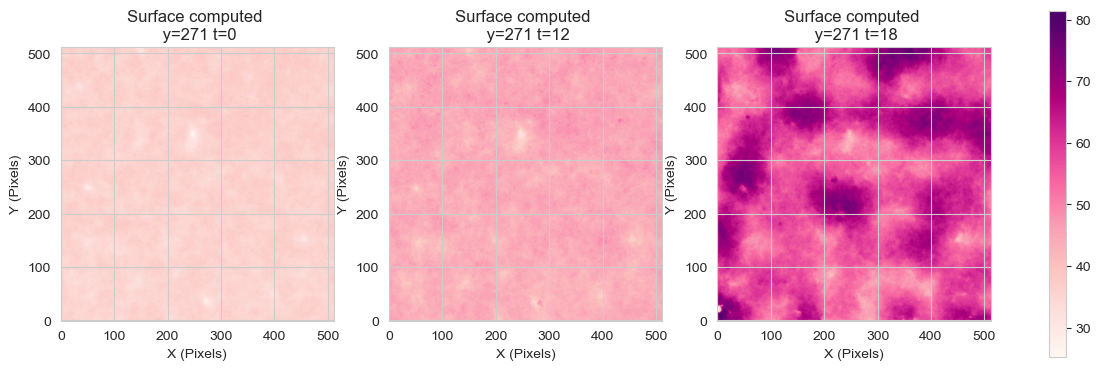

In [17]:

T =[0,12,18]
Y = [ 271,271,271]
ty = zip(T,Y)
vmin = np.nanmin([np.nanmin(surface[t]) for t in T])
vmax = np.nanmax([np.nanmax(surface[t]) for t in T])
fig, axes = plt.subplots(1,3,figsize=(15,15))

for i,(t,y) in enumerate(ty):
    im= axes[i].imshow(surface[t], origin='lower', cmap='RdPu', vmax = vmax, vmin = vmin )
    #ax2.hlines(y=y, xmin=0, xmax=h.shape[0], color='b')

    axes[i].set_xlabel('X (Pixels)')
    axes[i].set_ylabel('Y (Pixels)')
    axes[i].set_title('Surface computed \n y=%d t=%d'%(y,t))
    
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)

        
    # Show the plot
plt.show()


## <span color='red'> Intensity on surface membrane and motors

# preparation for geting values of intensity on membrane and surface

In [2]:
channel_name= ['Gel', 'Motors']
manifold_name = ['Membrane', 'Surface']
channel = 0
manifold = 0
membrane = np.load(MOVIE_PATH + 'np/membrane.npy')
surface = np.load(MOVIE_PATH + 'np/height.npy')
gel = np.load(MOVIE_PATH + 'np/gel_norm.npy')
membrane_mask = ~np.isnan(membrane)
surface_mask = ~np.isnan(surface)

membrane[np.isnan(membrane)] = 0
surface[np.isnan(surface)] = 0
membrane = membrane.astype(int)
surface = surface.astype(int)



# 3d plot of surface and membrane intensity motors and gels

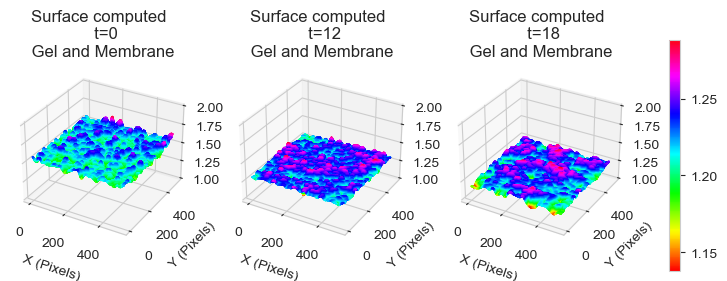

In [24]:
import numpy as np
import matplotlib.pyplot as plt
T =[0,12,18]
xx = np.arange(0, surface.shape[1])
yy = np.arange(0, surface.shape[2])
X, Y = np.meshgrid(xx, yy)

# Create random 3D array with dimensions (time, x, y)

for m_index, manifold in enumerate([surface-2]):#membrane+3, 
    for e_index ,experiment_data in enumerate([gel]):
        
        data = graph_utils.values_3d(experiment_data, manifold)
        #data [~np.bitwise_and(membrane_mask, surface_mask)]= np.nan
        vmin = np.nanmin([np.nanmin(data[t]) for t in T])
        vmax = np.nanmax([np.nanmax(data[t]) for t in T])

        label = channel_name[e_index] + ' and ' + manifold_name[m_index ]

        # Initialize the plot
        fig, axes = plt.subplots(1,len(T), figsize=(10, 10), subplot_kw={'projection': '3d'})
        

        for i,t in enumerate(T):
            Z = gaussian_filter(data[t],sigma =7)
            norm = Normalize(vmin=np.min(Z), vmax=np.max(Z))
            colors = plt.cm.hsv(norm(Z))
            axes[i].set_xlabel('X (Pixels)')
            axes[i].set_ylabel('Y (Pixels)')
            axes[i].set_title('Surface computed \n  t=%d\n %s'%(t,label))
            im = axes[i].plot_surface(X,Y,Z, rstride=1, cstride=1, facecolors=colors, shade=False)#, vmin= vmin, vmax =vmax)
            axes[i].set_zlim(1, 2)
        #plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)
        #plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)
        mappable = ScalarMappable(norm=norm, cmap=plt.cm.hsv)
        mappable.set_array(data[T])  # Set the data array

        # Now, create the colorbar
        plt.colorbar(mappable, ax=axes.ravel().tolist(), shrink=0.3, ticks = [1.15,1.2,1.25])

        plt.show()


# stat data

In [ ]:
#  ------- too complex 

monomoer_mean = pd.read_csv(MOVIE_PATH + 'np/monomer_rect.csv')['gaussian_mean']
monomer_std = pd.read_csv(MOVIE_PATH + 'np/monomer_rect.csv')['gaussian_std']

manifold_width_range = [0]
for m_index, manifold in enumerate([membrane,surface]): 
    for e_index ,experiment_data in enumerate([gel]):
        mean_list = []
        std_list = []
        data = graph_utils.values_3d(experiment_data, manifold)
        for t in range(0- manifold_width_range[0],len(experiment_data) - manifold_width_range[-1]):
            mean_list.append(np.nanmean([data[t + offset] for offset in manifold_width_range]))
            std_list.append(np.nanstd([data[t + offset] for offset in manifold_width_range]))
        plt.scatter(range(len(mean_list)),mean_list, label = channel_name[e_index] + ' + monomer on  ' + manifold_name[m_index ])
      

        plt.fill_between(np.arange(len(mean_list)), np.array(mean_list) - np.array(std_list), np.array(mean_list) + np.array(std_list), alpha=0.2)
    plt.scatter(range(len(mean_list)),monomer_mean, label = 'monomer mean intensity')
    plt.fill_between(np.arange(len(mean_list)), monomer_mean - monomer_std, monomer_mean + monomer_std, alpha=0.2)
plt.legend()
plt.title('Mean and std of intensity on manifold \n Movie = %s'%movie)
plt.show()

          

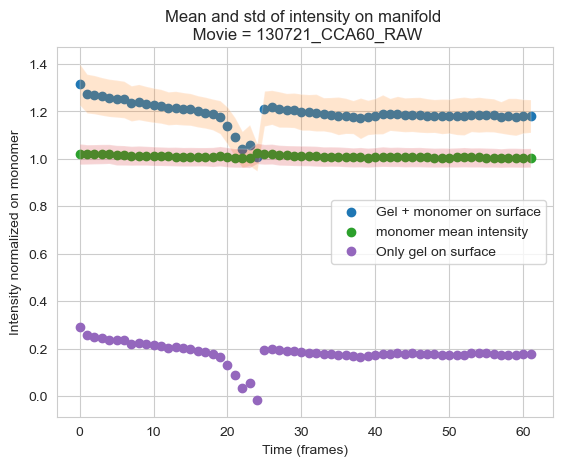

In [19]:
monomoer_mean = pd.read_csv(MOVIE_PATH + 'np/monomer_rect.csv')['gaussian_mean']
monomer_std = pd.read_csv(MOVIE_PATH + 'np/monomer_rect.csv')['gaussian_std']

manifold_width_range = [0]
manifold = surface
experiment_data = gel
mean_list = []
std_list = []
data = graph_utils.values_3d(experiment_data, manifold)
for t in range(0- manifold_width_range[0],len(experiment_data) - manifold_width_range[-1]):
    mean_list.append(np.nanmean([data[t + offset] for offset in manifold_width_range]))
    std_list.append(np.nanstd([data[t + offset] for offset in manifold_width_range]))
plt.scatter(range(len(mean_list)),mean_list, label =  'Gel + monomer on surface')
plt.fill_between(np.arange(len(mean_list)), np.array(mean_list) - np.array(std_list), np.array(mean_list) + np.array(std_list), alpha=0.2)
plt.scatter(range(len(mean_list)),monomer_mean, label = 'monomer mean intensity')
plt.fill_between(np.arange(len(mean_list)), monomer_mean - monomer_std, monomer_mean + monomer_std, alpha=0.2)
plt.scatter(range(len(mean_list)),mean_list - monomer_mean, label = 'Only gel on surface')
plt.legend()
plt.title('Mean and std of intensity on manifold \n Movie = %s'%movie)
plt.xlabel('Time (frames)')
plt.ylabel('Intensity normalized on monomer')
plt.show()

In [16]:
#reload graph_utils
importlib.reload(utils.graph_utils)   

<module 'utils.graph_utils' from 'C:\\Users\\amityu\\DataspellProjects\\gel_sheets\\utils\\graph_utils.py'>

## <span color='red'> 3d plot of surface height

# surface plot

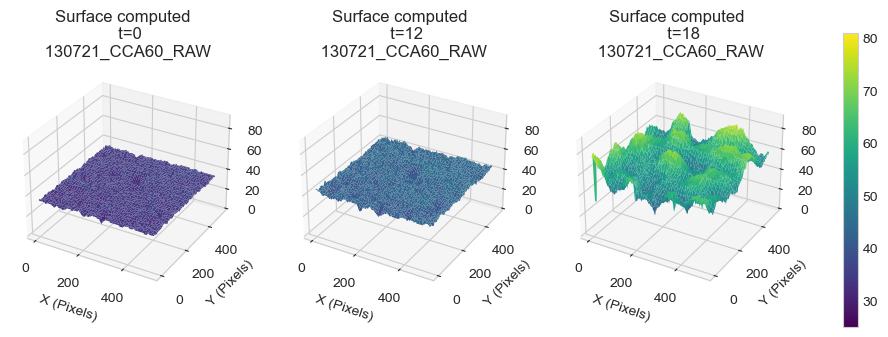

In [17]:
T =[0,12,18]
xx = np.arange(0, surface.shape[1])
yy = np.arange(0, surface.shape[2])
X, Y = np.meshgrid(xx, yy)
sigma =1 # smoothing of the height
# Create random 3D array with dimensions (time, x, y)

data = surface
#data [~np.bitwise_and(membrane_mask, surface_mask)]= np.nan
v_min = np.min([np.min(data[t]) for t in T])
v_max = np.max([np.max(data[t]) for t in T])

# Initialize the plot
fig, axes = plt.subplots(1,len(T), figsize=(10, 10), subplot_kw={'projection': '3d'})

norm = Normalize(vmin=v_min, vmax=v_max)
#colors = plt.cm.viridis(norm(data[T]))

for i,t in enumerate(T):
    Z = gaussian_filter(data[t],sigma =sigma)
    axes[i].set_xlabel('X (Pixels)')
    axes[i].set_ylabel('Y (Pixels)')
    axes[i].set_title('Surface computed \n  t=%d\n %s'%(t,movie))
    im = axes[i].plot_surface(X,Y,Z, cmap='viridis', norm=norm,  alpha =1, linewidth = 0)#, vmin= vmin, vmax =vmax)
    #im.set_clim(v_min, v_max)
    axes[i].set_zlim(0, v_max+10)
#plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)
#plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)
mappable = ScalarMappable(norm=norm, cmap= 'viridis'  )
#mappable.set_array(data[T])  # Set the data array

# Now, create the colorbar
plt.colorbar(mappable, ax=axes.ravel().tolist(), shrink=0.3)

plt.show()


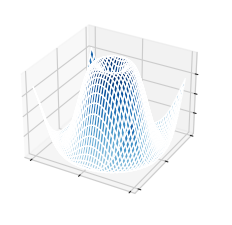

In [16]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm

plt.style.use('_mpl-gallery')

# Make data
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z, vmin=Z.min() * 2, cmap=cm.Blues)

ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

plt.savefig(MOVIE_PATH + "tmp/surface.png", dpi=300)

plt.show()

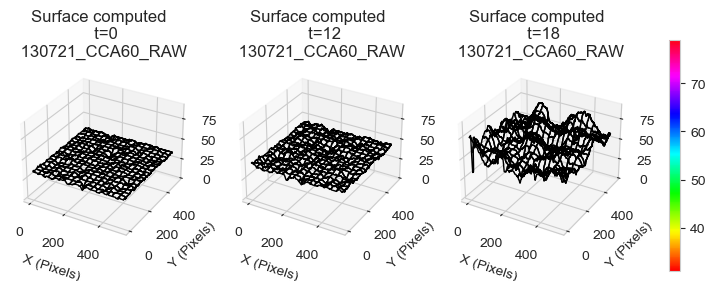

In [31]:
T =[0,12,18]
xx = np.arange(0, surface.shape[1])
yy = np.arange(0, surface.shape[2])
X, Y = np.meshgrid(xx, yy)
sigma =1 # smoothing of the height
# Create random 3D array with dimensions (time, x, y)

data = surface
#data [~np.bitwise_and(membrane_mask, surface_mask)]= np.nan
vmin = np.nanmin([np.nanmin(data[t]) for t in T])
vmax = np.nanmax([np.nanmax(data[t]) for t in T])

# Initialize the plot
fig, axes = plt.subplots(1,len(T), figsize=(10, 10), subplot_kw={'projection': '3d'})


for i,t in enumerate(T):
    Z = gaussian_filter(data[t],sigma =sigma)
    norm = Normalize(vmin=np.min(Z), vmax=np.max(Z))
    colors = plt.cm.hsv(norm(Z))
    axes[i].set_xlabel('X (Pixels)')
    axes[i].set_ylabel('Y (Pixels)')
    axes[i].set_title('Surface computed \n  t=%d\n %s'%(t,movie))
    im = axes[i].plot_surface(X, Y, Z, rstride=30, cstride=30, facecolors=None, edgecolor='k', shade=False, alpha = 0)
    axes[i].set_zlim(0, vmax+10)
#plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)
#plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3)
mappable = ScalarMappable(norm=norm, cmap=plt.cm.hsv)
mappable.set_array(data[T])  # Set the data array

# Now, create the colorbar
plt.colorbar(mappable, ax=axes.ravel().tolist(), shrink=0.3)

plt.show()


In [101]:
plt.savefig(r'\\132.72.218.248\Yuval_and_Shachar\evolution paper\\' + '%s_sideview_t%dy%d+membrane.png'%(movie,t,y))#, bbox_inches=extent)
plt.show()



<Figure size 640x480 with 0 Axes>